# Chicago: "we makin' cars"
Implement the Formula SAE contectualized design problem from Zurita et al

## TO DO: CHECK UNITS
everywhere, esp when importing tables

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import chi
# from opteval import benchmark_func as bf
import matplotlib

#for server:
# matplotlib.use('Agg')

#for retina display:
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import copy
import time as timer
import threading

from multiprocessing import Pool
from playsound import playsound
# from sklearn import linear_model

## Helper Functions

In [2]:
def cp(x): #make a copy instead of reference
    return copy.deepcopy(x)

def isNumber(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

def isNaN(num):
    return num != num

def mean(x):
    return np.mean(x)

def norm(x):
    return float(np.linalg.norm(x))

def dist(x,y):
    return np.linalg.norm(np.array(x)-np.array(y))

def bounds(x,low,high):
    if x > high:
        return high
    if x < low:
        return low
    return x

In [3]:
def makeAiScore():
    ai = np.random.normal(97,17)
    ai = bounds(ai, 40,150)
    return ai

def makeIqScore(): #this IQ ranges from 0 to 1, bc it is basically efficiency
    iq = np.random.normal(0.5,0.2)
    iq = bounds(iq, 0.1,1.0)
    return iq

def pickWorseScore(betterScore,worseScore,temperature):
    if temperature <=1E-6: #never pick worse answers, and avoid devide by 0
        return False
    if np.random.uniform(0,1) < np.exp((betterScore-worseScore)/temperature):  #
        return True 
    return False

def calculateDecay(steps,T0=1.0,Tf=0.01):
    if T0<=Tf or T0<=0: 
        return 0
    return (Tf / float(T0) ) ** (1/steps)
  
def calculateAgentDecay(agent, steps):
    E_N = normalizedE(agent.kai.E)
    E_transformed = np.exp((E_N*-1)+3.3)
    startEndRatio = bounds(1/E_transformed, 1E-10,1)
    T0 = agent.temp
    TF = T0 * startEndRatio
    return calculateDecay(steps,T0,TF)

In [4]:
def chaching():
    playsound("/Users/samlapp/SAE_ABM/missionComplete.wav")

## constants and params

In [108]:
complexSharing = True #if False, shareBasic() is used, eg strictly-greedy one-dimension jump 
commBonus = 10 #increasing the communication bonus makes successful communication more likely
commRange = 180
selfBias = 0 #increasing self bias will make agents choose their solutions more over others
startRange = 10
nDims = 56

SO_STRENGTH = 10
RG_STRENGTH = 10
TEAM_MEETING_COST = 1 #1 turn

VERBOSE = False
showViz = False

AVG_SPEED = 1
SD_SPEED = .5
MIN_SPEED = 1E-4
AVG_TEMP = 1
SD_TEMP = 0.5

## Load Table of parameters

In [6]:
#FIRST TIME:
paramsDF = pd.read_csv("./SAE/paramDB.csv")
paramsDF.columns = ['paramID','name','variable','team','kind','minV','maxV','used']
# paramsDF.at[3,"maxV"] = np.pi/4
# paramsDF.at[10,"maxV"] = np.pi/4
paramsDF.at[17,"maxV"] = np.pi /4
paramsDF.used = pd.to_numeric(paramsDF.used)
paramsDF = paramsDF.drop(columns=["paramID"],axis=1)
#remove unused variables... print(len(paramsDF))
paramsDF = paramsDF.loc[paramsDF.used > 0 ]
paramsDF.to_csv("./SAE/paramDBreduced.csv")
paramsDF = pd.read_csv("./SAE/paramDBreduced.csv")
print(len(paramsDF))
paramsDF = paramsDF.drop(["used"],axis=1)
paramsDF.head()

56


,Unnamed: 0,name,variable,team,kind,minV,maxV
0,0,rear wing height,hrw,rw,1,0.025,0.7
1,1,rear wing length,lrw,rw,1,0.05,0.25
2,2,rear wing width,wrw,rw,1,300,r_track-2*rear_wheel_r
3,3,rear wing angle of attack,arw,rw,1,0,0.7853981634
4,5,rear wing y position,yrw,rw,1,.500 + (h_rw)/2,1.200 - (h_rw)/2


In [7]:
paramsDF.loc[paramsDF.variable == "asw"]

,Unnamed: 0,name,variable,team,kind,minV,maxV
15,17,side wings angle of attack,asw,sw,1,0,0.7853981633974483


In [8]:
#logical vector for parameters with fixed min/max (TRUE), or min/max as f(p) (FALSE)
hasNumericBounds = [True if isNumber(row.minV) and isNumber(row.maxV) else False for i, row in paramsDF.iterrows()]

In [9]:
# materialsDF = pd.read_csv("/Users/samlapp/Documents/THRED Lab/SAE/materials.csv")
# materialsDF.q = [int(1 + np.random.uniform(0.98,1.02)*materialsDF.iloc[i]['q']) for i in range(len(materialsDF))]
# materialsDF.to_csv("/Users/samlapp/Documents/THRED Lab/SAE/materialsTweaked.csv")
materialsDF = pd.read_csv("./SAE/materialsTweaked.csv")
materialsDF.head()

,Unnamed: 0,Material,Code,q,E
0,0,Glass-filled epoxy (35%),GFE,1890,1900000000
1,1,Glass-filled polyester (35%),GFP,1989,2000000000
2,2,Glass-filled nylon (35%),GFN,1607,1600000000
3,3,S-glass epoxy (45%),SGE,1781,1800000000
4,4,Carbon epoxy (61%),CE,1627,1600000000


In [10]:
tiresDF = pd.read_csv("./SAE/tires.csv")
tiresDF

,ID,radius,mass
0,T1,0.22860,3.636
1,T2,0.22987,4.091
2,T3,0.23241,4.545
3,T4,0.24638,4.545
4,T5,0.24765,5.000
5,T6,0.26670,5.000
6,T7,0.26670,5.000
7,T8,0.26162,5.455


In [11]:
# motorsDF = pd.read_csv("/Users/samlapp/Documents/THRED Lab/SAE/motors.csv")
# # first time: we want to make motors with the same power slightly different:
# motorsDF.Power = [int(1 + np.random.uniform(0.98,1.02)*motorsDF.iloc[i]['Power']) for i in range(len(motorsDF))]
# motorsDF.to_csv("/Users/samlapp/Documents/THRED Lab/SAE/motorsTweaked.csv")
enginesDF = pd.read_csv("./SAE/motorsTweaked.csv")
print("unique" if len(enginesDF)-len(np.unique(enginesDF.Power)) == 0 else "not uniuqe")
enginesDF.columns = ["ind","id","name","le","we","he","me","Phi_e","T_e"]
enginesDF.head()

unique


,ind,id,name,le,we,he,me,Phi_e,T_e
0,0,M1,GX200,0.321,0.376,0.346,16.1,4157,912.4
1,1,M2,GX240,0.380,0.429,0.422,27.5,5980,18.3
2,2,M3,GX270,0.380,0.429,0.422,25.0,6208,19.1
3,3,M4,GX340,0.407,0.485,0.449,31.5,7866,26.4
4,4,M5,GXV340,0.433,0.382,0.406,32.3,6677,21.6


In [12]:
# susDF = pd.read_csv("/Users/samlapp/Documents/THRED Lab/SAE/suspension.csv")
# susDF.krsp = [int(np.random.uniform(0.98,1.02)*susDF.iloc[i]['krsp']) for i in range(len(susDF))]
# susDF.kfsp = susDF.krsp
# susDF.to_csv("/Users/samlapp/Documents/THRED Lab/SAE/suspensionTweaked.csv")
susDF = pd.read_csv("./SAE/suspensionTweaked.csv")
print("unique" if len(susDF)-len(np.unique(susDF.krsp)) == 0 else "not uniuqe")
susDF = susDF.drop(columns=[susDF.columns[0]])
susDF.head()

unique


,id,krsp,crsp,mrsp,kfsp,cfsp,mfsp
0,S1,3982,600,0.3,3982,600,0.3
1,S2,21189,2000,0.3,21189,2000,0.3
2,S3,20784,2000,0.3,20784,2000,0.3
3,S4,21231,2000,0.3,21231,2000,0.3
4,S5,20650,2000,0.3,20650,2000,0.3


In [13]:
# brakesDF = pd.read_csv("/Users/samlapp/Documents/THRED Lab/SAE/brakes.csv")
# brakesDF.columns = [a.strip() for a in brakesDF.columns]
# brakesDF.rbrk = [np.random.uniform(0.98,1.02)*brakesDF.iloc[i]['rbrk'] for i in range(len(brakesDF))]
# brakesDF.to_csv("/Users/samlapp/Documents/THRED Lab/SAE/brakesTweaked.csv")
brakesDF = pd.read_csv("./SAE/brakesTweaked.csv")
print("unique" if len(brakesDF)-len(np.unique(brakesDF['rbrk'])) == 0 else "not uniuqe")
brakesDF = brakesDF.drop(columns=[brakesDF.columns[0]])
brakesDF.head()

unique


,brakeID,qbrk,lbrk,hbrk,wbrk,tbrk,rbrk
0,B1,0.4,0.10,0.0425,0.0200,0.350,0.025447
1,B2,0.4,0.14,0.0490,0.0175,0.350,0.024598
2,B3,0.4,0.14,0.0615,0.0175,0.350,0.027990
3,B4,0.5,0.10,0.0380,0.0160,0.350,0.030169
4,B5,0.5,0.10,0.0425,0.0200,0.355,0.031523


In [14]:
# paramsDF.variable

In [15]:
class Params:
    def __init__(self,v = paramsDF):
        self.vars = v.variable
        self.team = v.team
        for i, row in v.iterrows():
            setattr(self, row.variable.strip(),-1)
p = Params()
for v in p.vars:
    value = np.random.uniform()
    setattr(p,v,value)
paramsDF.loc[paramsDF.variable=="hrw"]["team"][0]

teams = np.unique(paramsDF.team)
teamDimensions = [[row.team == t for i, row in paramsDF.iterrows()] for t in teams]
teamDictionary = {}
for i in range(len(teams)):
    teamDictionary[teams[i]] = teamDimensions[i]
paramList = np.array(paramsDF.variable)

In [16]:
#convert parameter vector to Parameter object
pNames = paramsDF.variable
blankParameterObject = Params()
def asParameters(pList):
    p = cp(blankParameterObject)
    for i in range(len(pList)):
        setattr(p,pNames[i],pList[i])
    return p

numberParameters = len(paramsDF)
def asVector(params):
    r = np.zeros(numberParameters)
    for i in range(numberParameters):
        pName = pNames[i]
        r[i] = getattr(params,pName)
    return r

In [17]:
p = startParams()
v = asVector(p)

NameError: name 'startParams' is not defined

In [18]:
%timeit asParameters(v)
%timeit asVector(p)

191 µs ± 9.61 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
454 µs ± 5.76 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Objective Subfunctions

### constants

The car’s top velocity vcar is 26.8 m/s (60 mph).

The car’s engine speed x_e is 3600 rpm. 

The density of air q_air during the race is 1.225 kg/m3. 

The track radio of curvature r_track is 9 m. 

The pressure applied to the brakes Pbrk is 1x10^7 Pa


In [19]:
#scale parameters to go between unit cube (approximately) and SI units
paramMaxValues = []

In [20]:
v_car = 26.8 #m/s (60 mph)
w_e = 3600 * 60 * 2 *np.pi #rpm  to radians/sec 
rho_air = 1.225 #kg/m3.
r_track = 9 #m
P_brk = 10**7 #Pascals
C_dc = 0.04 #drag coefficient of cabin
gravity = 9.81 #m/s^2

In [21]:
#mass (minimize)
def mrw(p):
    return p.lrw * p.wrw *p.hrw * p.qrw
def mfw(p):
    return p.lfw * p.wfw *p.hfw * p.qfw
def msw(p):
    return p.lsw * p.wsw *p.hsw * p.qsw
def mia(p):
    return p.lia * p.wia *p.hia * p.qia
def mc(p):
    return 2*(p.hc*p.lc*p.tc + p.hc*p.wc*p.tc + p.lc*p.hc*p.tc)*p.qc
def mbrk(p):
    #CHRIS missing parameters: how is mbrk calculated? assuming lrw*rho
    return p.lbrk * p.wbrk * p.hbrk * p.qbrk
def mass(p): #total mass, minimize
    mass = mrw(p) + mfw(p) + 2 * msw(p) + 2*p.mrt + 2*p.mft + p.me + mc(p) + mia(p) + 4*mbrk(p) + 2*p.mrsp + 2*p.mfsp
    return mass

In [22]:
#center of gravity height, minimize
def cGy(p): 
    t1 =  (mrw(p)*p.yrw + mfw(p)*p.yfw+ p.me*p.ye + mc(p)*p.yc + mia(p)*p.yia) / mass(p)
    t2 = 2* (msw(p)*p.ysw + p.mrt*p.rrt + p.mft*p.rft + mbrk(p)*p.rft + p.mrsp*p.yrsp + p.mfsp*p.yfsp) / mass(p)
    
    return t1 + t2  

In [23]:
#Drag (minimize) and downforce (maximize)
def AR(w,alpha,l): #aspect ratio of a wing
    return w* np.cos(alpha) / l
    
def C_lift(AR,alpha): #lift coefficient of a wing
    return 2*np.pi* (AR / (AR + 2)) * alpha

def C_drag(C_lift, AR): #drag coefficient of wing
    return C_lift**2 / (np.pi * AR)

def F_down_wing(w,h,l,alpha,rho_air,v_car): #total downward force of wing
    wingAR = AR(w,alpha,l)
    C_l = C_lift(wingAR, alpha)
    return 0.5 * alpha * h * w * rho_air * (v_car**2) * C_l

def F_drag_wing(w,h,l,alpha,rho_air,v_car): #total drag force on a wing
    wingAR = AR(w,alpha,l)
#     print(wingAR)
    C_l = C_lift(wingAR, alpha)
#     print(C_l)
    C_d = C_drag(C_l,wingAR)
#     print(C_d)
    return F_drag(w,h,rho_air,v_car,C_d)
    
def F_drag(w,h,rho_air,v_car,C_d):
    return 0.5*w*h*rho_air*v_car**2*C_d

def F_drag_total(p): #total drag on vehicle
    cabinDrag = F_drag(p.wc,p.hc,rho_air,v_car,C_dc)
    rearWingDrag = F_drag_wing(p.wrw,p.hrw,p.lrw,p.arw,rho_air,v_car)
    frontWingDrag = F_drag_wing(p.wfw,p.hfw,p.lfw,p.afw,rho_air,v_car)
    sideWingDrag = F_drag_wing(p.wsw,p.hsw,p.lsw,p.asw,rho_air,v_car)
    return rearWingDrag + frontWingDrag + 2* sideWingDrag + cabinDrag

def F_down_total(p): #total downforce
    downForceRearWing = F_down_wing(p.wrw,p.hrw,p.lrw,p.arw,rho_air,v_car)
    downForceFrontWing = F_down_wing(p.wfw,p.hfw,p.lfw,p.afw,rho_air,v_car)
    downForceSideWing = F_down_wing(p.wsw,p.hsw,p.lsw,p.asw,rho_air,v_car)
    return downForceRearWing + downForceFrontWing + 2*downForceSideWing

In [24]:
#acceleration (maximize)
def rollingResistance(p,tirePressure,v_car):
    C = .005 + 1/tirePressure * (.01 + .0095 * (v_car**2))
    return C * mass(p) * gravity

def acceleration(p):
    mTotal = mass(p)
    tirePressure = p.Prt #CHRIS should it be front or rear tire pressure?
    total_resistance = F_drag_total(p) + rollingResistance(p, tirePressure,v_car)
    
    w_wheels = v_car / p.rrt #rotational speed of rear tires
    
    efficiency = total_resistance * v_car / p.Phi_e
    
    torque = p.T_e
    
    #converted units of w_e from rpm to rad/s !!!
    F_wheels = torque * efficiency * w_e /(p.rrt * w_wheels) 
    
    return (F_wheels - total_resistance) / mTotal
# acceleration(p)

In [25]:
#crash force (minimize)
def crashForce(p):
    return np.sqrt(mass(p) * v_car**2 * p.wia * p.hia * p.Eia / (2*p.lia))

In [26]:
#impact attenuator volume (minimize)
def iaVolume(p):
    return p.lia*p.wia*p.hia

In [27]:
#corner velocity (maximize)
y_suspension = 0.05 # m
dydt_suspension = 0.025 #m/s 
def suspensionForce(k,c):
    return k*y_suspension + c*dydt_suspension

def cornerVelocity(p):
    F_fsp = suspensionForce(p.kfsp,p.cfsp)
    F_rsp = suspensionForce(p.krsp,p.crsp)
    downforce = F_down_total(p)
    mTotal = mass(p)
    
    #CHRIS again, rear tire pressure?
    C = rollingResistance(p,p.Prt,v_car)
    forces = downforce+mTotal*gravity-2*F_fsp-2*F_rsp
    if forces < 0: 
        return 0
    return np.sqrt( forces * C * r_track / mTotal )
# cornerVelocity(p)

In [28]:
#breaking distance (minimize)
def breakingDistance(p):
    mTotal = mass(p)
    C = rollingResistance(p,p.Prt,v_car)
    
    #CHRIS need c_brk break friction coef, and A_brk (rectangle or circle?)
    #breaking torque
    A_brk = p.hbrk * p.wbrk
    c_brk = .37 #?   most standard brake pads is usually in the range of 0.35 to 0.42
    Tbrk = 2 * c_brk * P_brk * A_brk * p.rbrk
    
    #y forces:
    F_fsp = suspensionForce(p.kfsp,p.cfsp)
    F_rsp = suspensionForce(p.krsp,p.crsp)
    Fy = mTotal*gravity + F_down_total(p) - 2 * F_rsp - 2*F_fsp
    
    #breaking accelleration
    #CHRIS front and rear tire radius are same? (rrt and rft)
    a_brk = Fy * C / mTotal + 4*Tbrk*C/(p.rrt*mTotal)
    
    #breaking distance
    return v_car**2 / (2*a_brk)
# breakingDistance(p)

In [29]:
#suspension acceleration (minimize)
def suspensionAcceleration(p):
    Ffsp = suspensionForce(p.kfsp,p.cfsp)
    Frsp = suspensionForce(p.krsp,p.crsp)
    mTotal = mass(p)
    Fd = F_down_total(p)
    return (2*Ffsp - 2*Frsp - mTotal*gravity - Fd)/mTotal
# suspensionAcceleration(p)

In [30]:
#pitch moment (minimize)
def pitchMoment(p):
    Ffsp = suspensionForce(p.kfsp,p.cfsp)
    Frsp = suspensionForce(p.krsp,p.crsp)
    
    downForceRearWing = F_down_wing(p.wrw,p.hrw,p.lrw,p.arw,rho_air,v_car)
    downForceFrontWing = F_down_wing(p.wfw,p.hfw,p.lfw,p.afw,rho_air,v_car)
    downForceSideWing = F_down_wing(p.wsw,p.hsw,p.lsw,p.asw,rho_air,v_car)
    #CHRIS assuming lcg is lc? and lf is ?
    lcg = p.lc
    lf = 0.5
    return 2*Ffsp*lf + 2*Frsp*lf + downForceRearWing*(lcg - p.lrw) - downForceFrontWing*(lcg-p.lfw) - 2*downForceSideWing*(lcg-p.lsw)  
# pitchMoment(p)

## Global Objective

In [31]:
#Global objective: linear sum of objective subfunctions
#sub-objectives to maximize will be mirrored *-1 to become minimizing

subObjectives = [mass,cGy,F_drag_total,F_down_total,acceleration,crashForce,iaVolume,cornerVelocity,breakingDistance,suspensionAcceleration,pitchMoment]  
alwaysMinimize = [1,1,1,-1,-1,1,1,-1,1,1,1] #1 for minimizing, -1 for maximizing
weightsNull = np.ones(len(subObjectives)) / len(subObjectives)
weights1 = np.array([14,1,20,30,10,1,1,10,10,2,1])/100
weights2 = np.array([25,1,15,20,15,1,1,15,5,1,1])/100
weights3 = np.array([14,1,20,15,25,1,1,10,10,2,1])/100

weightsCustom = np.array([14,1,20,30,11,1,1,10,10,2,0])/100 #pitch moment is zero bc incorrect eqn

def objectiveDetailedNonNormalized(p,weights):
    score = 0
    subscores = []
    for i in range(len(subObjectives)):
        obj = subObjectives[i]
        subscore = obj(p)
        subscores.append(subscore)
        score += weights[i]*alwaysMinimize[i]*subscore
    return score,subscores

# subscoreMean = np.zeros(len(subObjectives))
# subscoreSd = np.ones(len(subObjectives))

def objective(p,weights):
    score = 0
    for i in range(len(subObjectives)):
        obj = subObjectives[i]
        subscore= obj(p)
        normalizedSubscore = (subscore - subscoreMean[i]) / subscoreSd[i]
        score += weights[i]*alwaysMinimize[i]*normalizedSubscore
    return score

def objectiveDetailed(p,weights):
    score = 0
    subscores = []
    for i in range(len(subObjectives)):
        obj = subObjectives[i]
        subscore= obj(p)
        normalizedSubscore = (subscore - subscoreMean[i]) / subscoreSd[i]
        subscores.append(normalizedSubscore)
        score += weights[i]*alwaysMinimize[i]*normalizedSubscore
    return score, subscores

## Constraints

## constraints not done
I didnt actually do the constraint functions yet just bounds


In [32]:
#a list with all the min-max functions (!) which can be called to return max and min value as f(p)
minMaxParam = [None for i in range(len(paramsDF))]
def wrw(p):
    minV = 0.300
    maxV = r_track - 2 * p.rrt
    
    return minV, maxV
minMaxParam[paramsDF.loc[paramsDF.variable=="wrw"].index[0]] = wrw

# def xrw(p):
#     minV = p.lrw / 2
#     maxV = .250 - minV
#     return minV, maxV
# minMaxParam[paramsDF.loc[paramsDF.variable=="xrw"].index[0]] = xrw

def yrw(p):
    minV = .5 + p.hrw / 2
    maxV = 1.2 - p.hrw / 2
    return minV, maxV
minMaxParam[paramsDF.loc[paramsDF.variable=="yrw"].index[0]] = yrw
wheelSpace = .1 #?? don't have an equation for this rn, min is .075

aConst = wheelSpace
def lfw(p):
    minV = .05 
    maxV = .7 - aConst
    return minV, maxV
minMaxParam[paramsDF.loc[paramsDF.variable=="lfw"].index[0]] = lfw

f_track = 3 # bounds: 3, 2.25 m 
def wfw(p):
    minV = .3
    maxV = f_track
    return minV, maxV
minMaxParam[paramsDF.loc[paramsDF.variable=="wfw"].index[0]] = wfw

# def xfw(p):
#     minV = p.lrw + p.rrt + p.lc + p.lia + p.lfw/2
#     maxV = .25 + p.rrt + p.lc + p.lia + p.lfw/2
#     return minV, maxV
# minMaxParam[paramsDF.loc[paramsDF.variable=="xfw"].index[0]] = xfw

xConst = .030 #ground clearance 19 to 50 mm
def yfw(p):
    minV = xConst + p.hfw / 2
    maxV = .25 - p.hfw/2
    return minV, maxV
minMaxParam[paramsDF.loc[paramsDF.variable=="yfw"].index[0]] = yfw

# def xsw(p):
#     minV = p.lrw + 2*p.rrt + aConst + p.lsw / 2
#     maxV = .250 + 2*p.rrt + aConst + p.lsw / 2
#     return minV, maxV
# minMaxParam[paramsDF.loc[paramsDF.variable=="xsw"].index[0]] = xsw

def ysw(p):
    minV = xConst + p.hsw/2
    maxV = .250 - p.hsw/2
    return minV, maxV
minMaxParam[paramsDF.loc[paramsDF.variable=="ysw"].index[0]] = ysw

# def xrt(p):
#     minV = p.lrw + p.rrt
#     maxV = .250 + p.rrt 
#     return minV, maxV
# minMaxParam[paramsDF.loc[paramsDF.variable=="xrt"].index[0]] = xrt

# def xft(p):
#     minV = p.lrw + p.rrt + p.lc
#     maxV = .250 + p.rrt  + p.lc
#     return minV, maxV
# minMaxParam[paramsDF.loc[paramsDF.variable=="xft"].index[0]] = xft

# def xe(p):
#     minV = p.lrw + p.rrt - p.le / 2
#     maxV = p.lrw + aConst + p.rrt - p.le / 2
#     return minV, maxV
# minMaxParam[paramsDF.loc[paramsDF.variable=="xe"].index[0]] = xe

def ye(p):
    minV = xConst + p.he / 2
    maxV = .5 - p.he / 2
    return minV, maxV
minMaxParam[paramsDF.loc[paramsDF.variable=="ye"].index[0]] = ye

def hc(p):
    minV = .500
    maxV = 1.200 - xConst
    return minV, maxV
minMaxParam[paramsDF.loc[paramsDF.variable=="hc"].index[0]] = hc

# def xc(p):
#     minV = p.lrw + p.rrt + p.lc / 2
#     maxV = .250 + p.rrt + p.lc / 2
#     return minV, maxV
# minMaxParam[paramsDF.loc[paramsDF.variable=="xc"].index[0]] = xc

def yc(p):
    minV = xConst + p.hc / 2
    maxV = 1.200 - p.hc / 2
    return minV, maxV
minMaxParam[paramsDF.loc[paramsDF.variable=="yc"].index[0]] = yc

def lia(p):
    minV = .2
    maxV = .7  - p.lfw # what is l_fr?
    return minV, maxV
minMaxParam[paramsDF.loc[paramsDF.variable=="lia"].index[0]] = lia

# def xia(p):
#     minV = p.lrw + p.rrt + p.lc + p.lia / 2
#     maxV = .250 + p.rrt + p.lc + p.lia/ 2
#     return minV, maxV
# minMaxParam[paramsDF.loc[paramsDF.variable=="xia"].index[0]] = xia

def yia(p):
    minV = xConst + p.hia / 2
    maxV = 1.200 - p.hia / 2
    return minV, maxV
minMaxParam[paramsDF.loc[paramsDF.variable=="yia"].index[0]] = yia

def yrsp(p):
    minV = p.rrt
    maxV = p.rrt * 2
    return minV, maxV
minMaxParam[paramsDF.loc[paramsDF.variable=="yrsp"].index[0]] = yrsp

def yfsp(p):
    minV = p.rft
    maxV = p.rft * 2
    return minV, maxV
minMaxParam[paramsDF.loc[paramsDF.variable=="yfsp"].index[0]] = yfsp

#test:
# for f in minMaxParam:
#     if f is not None:
#         print(f(p))

In [33]:
def getAttr(obj):
    return [a for a in dir(obj) if not a.startswith('__')]

In [34]:
def findMaterialByDensity(rho):
    differences = abs(np.array(materialsDF.q) - rho)
    material = materialsDF.iloc[np.argmin(differences)]
    return material.Code, material.q, material.E
def findTireByRadius(radius):
    differences = abs(np.array(tiresDF.radius) - radius)
    tire = tiresDF.iloc[np.argmin(differences)]
    return tire.ID, tire.radius, tire.mass

def findEngineByPower(power):
    differences = abs(np.array(enginesDF.Phi_e) - power)
    engine = enginesDF.loc[np.argmin(differences)]
    return engine

def findSuspensionByK(k):
    differences = abs(np.array(susDF.krsp) - k)
    sus = susDF.loc[np.argmin(differences)]
    return sus

def findBrakesByR(r): #what is the driving variable for brakes??? r?
    differences = abs(np.array(brakesDF.rbrk) - r)
    brakes = brakesDF.loc[np.argmin(differences)]

    return brakes

In [35]:
def constrain(p,dimsToConstrain=np.ones(len(paramsDF))):
#     p_attribute = getAttr(p)
    paramIndices = [i for i in range(len(dimsToConstrain)) if dimsToConstrain[i] ==1]
    for i in paramIndices: #range(len(paramsDF)): # we need to do the equations bounds last
#         if not dimsToConstrain[i]: #we don't need to check this dimension, it didn't change
#             continue
        param = paramsDF.loc[i]
        variable = param.variable
        value = getattr(p,variable)
        if param.kind == 1: #continuous param with min and max
            if hasNumericBounds[i]:
                newValue = bounds(value,float(param["minV"]),float(param["maxV"]))
                setattr(p,variable,newValue)
            #do the equation ones after setting all other parameters
                
        elif param.kind == 2: #choose a material based on density
            materialID,density,modulusE = findMaterialByDensity(value)
            setattr(p,variable,density)
            #find other variables that are driven by this one:
            for i, otherParam in paramsDF[paramsDF.team == variable].iterrows():#dimension is driven by this one
                setattr(p,otherParam.variable,modulusE)    
        elif param.kind == 3: #choose tires
            tireID,radius,weight = findTireByRadius(value)
            setattr(p,variable,radius)
            #find other variables that are driven by this one:
            for i, otherParam in paramsDF[paramsDF.team == variable].iterrows():
                setattr(p,otherParam.variable,weight)
        elif param.kind == 4: #choose motor
            tableRow= findEngineByPower(value) #Phi_e,l_e,w_e,h_e,T_e,m_e
            setattr(p,variable,tableRow[variable])
            #find other variables that are driven by this one:
            for i, otherParam in paramsDF[paramsDF.team == variable].iterrows():
                setattr(p,otherParam.variable,tableRow[otherParam.variable])
        elif param.kind == 5: #choose brakes
            tableRow = findBrakesByR(value) # r is driving variable

            setattr(p,variable,tableRow[variable]) #df columns need to be same as variable names
            #find other variables that are driven by this one:
            for i, otherParam in paramsDF[paramsDF.team == variable].iterrows():
            #their "team" is THIS VAR: dimension is driven by this
                setattr(p,otherParam.variable,tableRow[otherParam.variable])

        elif param.kind == 6: #choose suspension
            tableRow = findSuspensionByK(value) #kfsp, cfsp, mfsp
            setattr(p,variable,tableRow[variable])
            #find other variables that are driven by this one:
            for i, otherParam in paramsDF[paramsDF.team == variable].iterrows():#their "team" is THIS VAR: dimension is driven by this
                setattr(p,otherParam.variable,tableRow[otherParam.variable])
    
    #now we can do the ones that depend on other variables
    for i in paramIndices: 
        param = paramsDF.loc[i]
        variable = param.variable
        value = getattr(p,variable)
        if param.kind == 1 and not hasNumericBounds[i]:
            f = minMaxParam[i] #list of minMax functions for each variable
            minV, maxV = f(p) 
            newValue = bounds(value,minV,maxV)
            setattr(p,variable,newValue)
    return p

## create the scaling vector

In [36]:
pVmax = asParameters([1e30 for i in range(len(paramsDF))])
maxVals = pVmax
maxVals = constrain(pVmax)
scalingVector = asVector(maxVals) #this acts as a scaling vector to map SI unit values to ~unit cube
# paramsDF.iloc[11]

## create realistic starting values

In [37]:
def startParams(returnParamObject=True):
    nParams = len(paramsDF)
    pV = np.random.uniform(0,1,nParams) * scalingVector
    p = constrain(asParameters(pV))
#     print(asVector(p))
    return p if returnParamObject else asVector(p)
# objective(p,weightsCustom)

In [38]:
# p = startParams()
# constrained = asVector(p)
# # constrained/ scalingVector
# for i, row in paramsDF.iterrows():
#     print(row[1] + " : \t"+str(constrained[i]))

### run random possible start values through objectives to get distribution of outputs

In [39]:
# subscores = []
# for i in range(2000):
#     p = startParams()
#     _,ss = objectiveDetailedNonNormalized(p,weightsNull)
#     subscores.append(ss)
# s = np.array(subscores)

In [40]:
# x = s[:,7]
# s[:,7 ] = [3000 if isNaN(x[i]) else x[i] for i in range(len(x)) ]

### capture the mean and standard deviations of subscores
so that we can normalize them assuming Normal dist.
Now, the objective function will fairly weight sub-objectives using custom weights

In [41]:
# #FIRST TIME, need to run this if we don't have the file with saved values
# subscoreMean = []
# subscoreSd = []
# for i in range(len(subscores[0])):
#     subscoreMean.append(np.mean(s[:,i]))
#     subscoreSd.append(np.std(s[:,i]))

# subscoreStatsDF = pd.DataFrame(columns=["subscoreMean","subscoreSD"],data=np.transpose([subscoreMean,subscoreSd]))
# subscoreStatsDF.to_csv("./SAE/subscoreStatsDF.csv")

# #     plt.hist((np.array(s[:,i]) - subscoreMean[i])/subscoreSd[i])
# #     plt.show()

In [42]:
subscoreStatsDF = pd.read_csv("./SAE/subscoreStatsDF.csv")
subscoreMean = list(subscoreStatsDF.subscoreMean)
subscoreSd = list(subscoreStatsDF.subscoreSD)

In [46]:
objective(startParams(),weightsCustom)

-1.2512569551431818

# Create Virtual Population with represntative KAI scores 
based on KAI score and subscore dataset provided by Dr. J

In [77]:
kaiDF_DATASET = pd.read_csv("./KAI/KAI_DATA_2018_07_09.csv")
kaiDF_DATASET.columns = ["KAI","SO","E","RG"]
def makeKAI(n=1,asDF=True):
    pop = np.random.multivariate_normal(kaiDF_DATASET.mean(),kaiDF_DATASET.cov(),n)
    if asDF:
        popDF = pd.DataFrame(pop) 
        popDF.columns = kaiDF_DATASET.columns
        return popDF if n>1 else popDF.loc[0]
    else:
        return pop if n>1 else pop[0]
    
# def makeSubscores(kai,n=1,asDF=True):
#     pop = np.random.multivariate_normal(kaiDF_DATASET.mean(),kaiDF_DATASET.cov(),n)
kaiPopulation = makeKAI(100000)
kaiPopulation=kaiPopulation.round()

In [78]:
def findAiScore(kai):
    kai = int(kai)
    a = kaiPopulation.loc[kaiPopulation['KAI'] == kai]
    ind = np.random.choice(a.index)
    me = kaiPopulation.loc[ind]
    return KAIScore(me) #this is a KAIScore object

In [79]:
def normalizedAI(ai):
    return (ai - kaiDF_DATASET.mean().KAI)/kaiDF_DATASET.std().KAI
def normalizedRG(rg):
    return (rg - kaiDF_DATASET.mean().RG)/kaiDF_DATASET.std().RG
def normalizedE(E):
    return (E - kaiDF_DATASET.mean().E)/kaiDF_DATASET.std().E
def normalizedSO(SO):
    return (SO - kaiDF_DATASET.mean().SO)/kaiDF_DATASET.std().SO

In [80]:
kaiDF_DATASET.mean().E
kaiDF_DATASET.std().E

5.251845955448993

In [81]:
def dotNorm(a,b): #return normalized dot product (how parallel 2 vectors are, -1 to 1)
    if norm(a) <= 0 or norm(b)<= 0:
#         print("uh oh, vector was length zero")
        return 0
    a = np.array(a)
    b = np.array(b)
    dotAB = np.sum(a*b)
    normDotAB = dotAB / (norm(a)*norm(b))
    return normDotAB

In [82]:
def plotCategoricalMeans(x,y):
    categories = np.unique(x)
    means = []
    sds = []
    for c in categories:
        yc = [y[i] for i in range(len(y)) if x[i] == c]
        means.append(np.mean(yc))
        sds.append(np.std(yc))
    plt.errorbar(categories,means,yerr=sds,marker='o',ls='none')
    
    return means

In [83]:
#speed distributions:
dfConstant=1.9
def travelDistance(speed): #how far do we go? chi distribution, but at least go 0.1 * speed
    r = np.max([chi.rvs(dfConstant),0.1]) 
    return r * speed

In [84]:
def memoryWeightsPrimacy(n):
    if n==1:
        return np.array([1])
    weights = np.arange(n-1,-1,-1)**3*0.4 + np.arange(0,n,1)**3
    weights = weights / np.sum(weights)
    return weights

In [85]:
def aiColor(ai): #red for innovators, blue for adaptors
    ai01 = bounds((ai - 40)/ 120,0,1)
    red = ai01
    blue = 1 - ai01
    return (red,0,blue)

In [86]:
def makeParamString():
    s= ""
    s+= "steps: "+ str(steps) + " \n"
    s+= "self-bias: " +str(selfBias)+ " \n"
    s+= "num agents: " +str(nAgents)+ " \n"
    s+= "rg strength: " +str(RG_STRENGTH)+ " \n"
    s+= "so strength: " +str(SO_STRENGTH)+ " \n"
    s+= "repeats: " +str(reps)+ " \n"
    s+= "avg speed: " +str(AVG_SPEED) + " \n"
    s+= "sd speed: " + str(SD_SPEED)+ " \n"
    s+= "min speed: " +str(MIN_SPEED)+ " \n"
    s+= "avg temp: "+ str(AVG_TEMP)+ " \n"
    s+= "sd temp: " +str(SD_TEMP)+ " \n"
    return s

## Agent and Team Classes

In [87]:
class Agent:
    def __init__(self, id=-1):
        self.id = id
        self.score = np.inf
        self.params = startParams()
        self.r = asVector(self.params)
        self.rNorm = self.r / scalingVector
        self.nmoves = 0
        self.kai = KAIScore()
        self.speed = bounds(AVG_SPEED + normalizedAI(self.kai.KAI) * SD_SPEED, MIN_SPEED ,np.inf)
        self.temp = bounds(AVG_TEMP + normalizedE(self.kai.E) * SD_TEMP, 0 ,np.inf)
        self.iq = 1 #makeIqScore()
        self.memory = [Solution(self.r,self.score,self.id,type(self))]
        self.team = -1
        self.decay = calculateAgentDecay(self,100)
        self.startTemp = self.temp
        self.startSpeed = self.speed
        
    def move(self,soBias=False,groupConformityBias=False,teamPosition=None):
        if np.random.uniform()>self.iq: #I'm just thinking this turn
            return False 
        
#         print("my dimensions:" +str(self.myDims))
        #pick a new direction
        d = np.random.uniform(-1,1,nDims)
        d = d * self.myDims #project onto the dimensions I can move
        dn = np.linalg.norm(d)
        if dn==0: print("divide by zero (dn)")
        #distance moved should be poisson distribution, rn its just my speed
        distance = travelDistance(self.speed) * nDims
        d = d / dn * distance
#         print('considering moving '+str(d) + ' from '+str(self.r))
        candidateSolution = asParameters((self.rNorm + d)*scalingVector)
        candidateSolution = constrain(candidateSolution,self.myDims)
        
        acceptsNewSolution = self.evaluate(candidateSolution,soBias,groupConformityBias,teamPosition=teamPosition)
        if acceptsNewSolution: 
            self.moveTo(asVector(candidateSolution))
            return True
        self.score = self.f()
        return False

    def moveTo(self, r):
        self.r = r
        self.rNorm = self.r / scalingVector
        self.params = asParameters(self.r)
        self.score = self.f()
        self.memory.append(Solution(self.r,self.score,self.id,type(self)))
        self.nmoves += 1
        
    def startAt(self,position):
        self.r = position
        self.rNorm = self.r / scalingVector
        self.params = asParameters(self.r)
        self.memory = [Solution(r=self.r,score=self.f(),owner_id=self.id,agent_class=type(self))]

    def wantsToTalk(self,pComm):
        if(np.random.uniform() < pComm):
            return True
        return False
    
    def getBestScore(self):
        bestScore = self.score
        for s in self.memory:
            if s.score < bestScore:
                bestScore = s.score
        return bestScore
    
    def getBestSolution(self):
        bestSolution = self.memory[0]
        for m in self.memory:
            if m.score < bestSolution.score:
                bestSolution = m
        return bestSolution
    
    def soBias(self,currentPosition,candidatePosition): #influences preference for new solutions, f(A-I)
        #positions should be given as NORMALIZED positions on unit cube! 
        soNorm = normalizedSO(self.kai.SO) #normalized score for Sufficiency of Originality
        memSize = len(self.memory) 
        if memSize < 2: return 0 #we don't have enough places be sticking around them
        
        candidateDirection = candidatePosition - currentPosition #in unit cube space
        
        memDirection = 0 # what is the direction of past solns from current soln?
        weights = memoryWeightsPrimacy(memSize) #weights based on temporal order, Recency and Primacy Bias
        for i in range(memSize-1): #don't include current soln
            past_soln = self.memory[i]
            pairwiseDiff = past_soln.rNorm - currentPosition
            memDirection += pairwiseDiff * weights[i]
        #now we see if the new solution is in the direction of the memories or away from the memories
        paradigmRelatedness = dotNorm(memDirection, candidateDirection)
        raw_PR_score = soNorm * (paradigmRelatedness + 0) #shifting the x intercept #biasOfSO(PR,soNorm)
        sufficiency_of_originality = raw_PR_score*SO_STRENGTH #the agent should have a memory of their path & interactions
            
        return sufficiency_of_originality
    
    def groupConformityBias(self,teamPosition,currentPosition,candidatePosition): #influences preference for new solutions, f(A-I)
        rgNorm = normalizedRG(self.kai.RG) #normalized score for Rule/Group Conformity
        candidateDirection = candidatePosition - currentPosition 
        
        #all teammates have equal weight
        teamDirection = teamPosition - currentPosition

        #now we see if the new solution is in the direction of the team or away from the team
        groupConformity = dotNorm(teamDirection, candidateDirection)
        nominalGC = 0 #can change intercept with -0 (using dot product of direction,so is perpendicular the null case?)
        groupConformityBias = (groupConformity-nominalGC)*rgNorm*RG_STRENGTH 
        return groupConformityBias
    
    def evaluate(self,candidateSolution,soBias=False,groupConformityBias=False,teamPosition=None): #implements simulated annealing greediness
        candidateSolutionNorm = asVector(candidateSolution) / scalingVector
        candidateScore = self.fr(candidateSolution)
        if soBias:
            candidateScore += self.soBias(self.rNorm,candidateSolutionNorm)
        if groupConformityBias:
            gcB = self.groupConformityBias(teamPosition,self.rNorm,candidateSolutionNorm)
            candidateScore += gcB
        #if better solution, accept
        if candidateScore < self.score:
            return True
        #accept worse solution with some probability, according to exp((old-new )/temp)
        elif pickWorseScore(self.score,candidateScore,self.temp):
            self.score = candidateScore #(its worse, but we go there anyways)
            return True              
        return False
    
    
#Solutions are objects
class Solution():
    def __init__(self, r,  score, owner_id=None, agent_class=None):
        self.r = cp(r)
        self.rNorm = self.r / scalingVector
        self.score = cp(score)
        self.owner_id = cp(owner_id)
        self.agent_class = cp(agent_class)
        
#KAI scores are objects 
class KAIScore():
    def __init__(self,subscores=None):
        if subscores is None:
            subscores = makeKAI(1,True)
        self.KAI = subscores.KAI
        self.SO = subscores.SO
        self.E = subscores.E
        self.RG = subscores.RG
    
#subclasses (Types) of Agents
class carDesigner(Agent):
    def __init__(self, id=-1):
        Agent.__init__(self,id)
        self.myDims = [1 for t in paramsDF.team ] #owns all dimensions by default
#         self.params = startParams() ##these already set in class Agent()
#         self.r = asVector(params)
#         self.rNorm = self.r / scalingVector
         
    def f(self):
        return objective(self.params,weightsCustom)
    def fr(self,params):
        return objective(params,weightsCustom)
    
class cabinPerson(Agent):
    def __init__(self, id=-1):
        Agent.__init__(self,id)
        self.myDims = [( 1 if t == "c" else 0 ) for t in paramsDF.team ]
#         self.r = np.random.uniform(-1*startRange,startRange,nDims)
        self.params = startParams() # asParameters(self.r)
        
    def f(self):
        return objective(self.params,weightsCustom)
    def fr(self,params):
        return objective(params,weightsCustom)
    
# class Steinway(Agent): #tuneable roughness
#     def __init__(self, id=-1):
#         Agent.__init__(self,id)
#         self.myDims = np.ones(nDims)
#         self.r = np.random.uniform(-1*startRange,startRange,nDims)
        
#     def f(self):
#         return testy(self.r,ROUGHNESS)
#     def fr(self,r):
#         return testy(r,ROUGHNESS)

# class LewisMultiDim(Agent): #objective is beauty
#     def __init__(self,id=-1):
#         Agent.__init__(self,id)
#         self.myDims = np.ones(nDims) #logical vector, LewD controls/varies x0 AND x1
        
#     def f(self):
#         return ellipsoid(self.r)
#     def fr(self,r):
#         return ellipsoid(r)

def tryToShare(a1,a2):
    deltaAi = abs(a1.kai.KAI - a2.kai.KAI) #harder to communicate above 20, easy below 10
    successful =  tryComm(deltaAi)
    if successful: #in share(), agents might adopt a better solution depending on their temperature
        share(a1,a2) if complexSharing else shareBasic(a1,a2)
        return True
    return False

# def softShare(a1,a2): #share position with some error
#     deltaAi = abs(a1.ai - a2.ai) #hard to communicate above 20, easy below 10
#     #the higher the deltaAi, the more noise in sharing position
#     e = np.random.normal(10,10)
#         return True
#     return False
    
# def shareBasic(a1,a2): #always share
#     for i in range(len(a1.myDims)):
#         if(a1.myDims[i]>0):
#             #a1 controls this dimension, but a2 only follows if it helps them
#             candidateSoln = a2.params #other dimensions won't change
#             candidateSoln[i] = a1.r[i] #tells a1 where to go in This [i] dimension only
#             if(a2.fr(candidateSoln)<a2.score): #self-bias goes here
#                 a2.r = candidateSoln
#                 a2.params = asParameters(a2.r)
#                 a2.score = a2.f()
# #                 print('shared')
         
#         elif(a2.myDims[i]>0):
#             #a1.r[i]=a2.r[i] #for naive follow
#             candidateSoln = a1.r 
#             candidateSoln[i] = a2.r[i] 
#             if(a1.fr(candidateSoln)<a1.score): 
#                 a1.r = candidateSoln
#                 a1.params = asParameters(a1.r)
#                 a1.score = a1.f()
# #                 print('shared')
#     return True
        
def share(a1,a2): #agent chooses whether to accept new solution or not, holistic NOTTTTTT dimension by dimension
    copyOfA1 = cp(a1)
    considerSharedSoln(a1,a2)
    considerSharedSoln(a2,copyOfA1) #so they could theoretically swap positions...
    return True

def considerSharedSoln(me,sharer): #,dim): #will only move (jump) in the dimensions that sharer controls
#         candidateSoln = me.r #other dimensions won't change
#         candidateSoln[dim] = sharer.r[dim] #tells a1 where to go in This [i] dimension only
        candidateSolution = sharer.params
        candidateScore = me.fr(candidateSolution)
        myScore = me.score - selfBias #improve my score by selfBias
        #Quality Bias Reduction? would go here
        if(candidateScore<myScore):
            if not pickWorseScore(candidateScore,myScore,me.temp): #sometimes choose better, not always
                me.moveTo(asVector(candidateSolution))  #(but never take a worse score from a teammate)
#                 me.speed = me.startSpeed
#                 me.temp = me.startTemp # !! CHRIS trying somethign new here: restart temp at teammate's soln
constructor = carDesigner

In [88]:
# commBonus = 0
# commRange = 200
def tryComm(deltaAi):
    c = np.random.uniform(commBonus,commBonus+commRange) #increasing commBonus makes sharing easier 
    return (deltaAi < c )

In [89]:
class Team(): #a group of agents working on the same dimension and objective function
    def __init__(self, nAgents, agentConstructor, dimensions = np.ones(nDims), specializations = None, temp=None,speed=None,aiScore=None,aiRange=None,startPositions=None):
        self.agents = []
        self.dimensions = dimensions
        if (aiScore is not None) and (aiRange is not None):
            minScore = np.max([40, aiScore-aiRange/2.0])
            maxScore = np.min([150,aiScore+aiRange/2.0])
            aiScores = np.linspace(minScore,maxScore,nAgents)
            np.random.shuffle(aiScores) #randomly assign these to agents, not in order...
            #or we could try putting them in subteams according to a rule:
            
        for i in range(nAgents):
            a = agentConstructor(id = i)
            if startPositions is not None:
                a.startAt(startPositions[i])
            if (aiScore is not None) and (aiRange is not None):
                aiScore = aiScores[i]
                a.kai = findAiScore(aiScore)
                a.speed = bounds(AVG_SPEED + normalizedAI(a.kai.KAI) * SD_SPEED, MIN_SPEED ,np.inf)
                a.temp = bounds(AVG_TEMP + normalizedE(a.kai.E) * SD_TEMP, 0 ,np.inf)
            if speed is not None:
                a.speed = speed
            if temp is not None:
                a.temp = temp
            a.startSpeed = a.speed
            a.startTemp = a.temp
            a.myDims = dimensions #default: all dimensions owned by every agent
            self.agents.append(a)
        self.nAgents = nAgents
        aiScores = [a.kai.KAI for a in self.agents]
        self.dAI = np.max(aiScores)- np.min(aiScores)
        self.nMeetings = 0
        self.nTeamMeetings = 0
        self.subTeamMeetings = 0
        
        self.scoreHistory = []
        
        #if there are subteams owning certain dimensions, each subteams dimensions are listed in a matrix
        self.specializations = specializations
        
#         #we should give them same position in the dimensions they don't control
#         a0 = self.agents[0]
#         for i in range(len(a0.myDims)):
#             if not a0.myDims[i]:  #this isn't our dimension to control
#                 for a in self.agents: 
#                     a.r[i] = a0.r[i] 

    def getSharedPosition(self): #this is in the normalized space
        positions = np.array([a.rNorm for a in self.agents])
        return [np.mean(positions[:,i]) for i in range(len(positions[0]))]
    
    def getSubTeamPosition(self,team): #this is in the normalized space
        positions = np.array([a.rNorm for a in self.agents if a.team == team])
        return [np.mean(positions[:,i]) for i in range(len(positions[0]))]
    
    def getBestScore(self):
        return np.min([a.getBestScore() for a in self.agents])
    
    def getBestSolution(self):
        allSolns = [a.getBestSolution() for a in self.agents]
        allScores = [s.score for s in allSolns]
        return allSolns[np.argmin(allScores)]
    
    def getBestTeamSolution(self,team=-1): #returns a Solution object 
        bestIndividualSolns = [a.getBestSolution() for a in self.agents if a.team == team ]
        bestScoreLocation = np.argmin([s.score for s in bestIndividualSolns])
        return bestIndividualSolns[bestScoreLocation]
    
    def haveMeetings(self,talkers):
        nMeetings = 0
        for i in np.arange(0,len(talkers)-1,2):
            #if you don't have a partner, you don't talk to anyone?
            #this needs to be adjusted
            a1 = talkers[i]
            a2 = talkers[i+1]
            didShare = tryToShare(a1,a2)
            if didShare: 
#                 print(str(a1.id) + ' and '+str(a2.id)+' shared!')
                nMeetings +=1
        self.nMeetings += nMeetings
        return nMeetings
    
    def haveTeamMeeting(self):
        #they all go to the best position of the group
        bestSolution = self.agents[0].getBestSolution()
        for a in self.agents:
            agentBest = a.getBestSolution()
            if agentBest.score < bestSolution.score:
                bestSolution = agentBest
        #now move all agents to this position
        for a in self.agents:
            a.moveTo(bestSolution.r)
            
        return bestSolution
    
    def haveSubTeamMeeting(self,team,gap=False):
        #they all go to the best position of their specialized team
        teamAgents = [a for a in self.agents if a.team == team]
        if gap: #the meeting might fail if the cognitive style gap is large
            #take the KAI differences of the team into account
            kaiScores = [a.kai.KAI for a in teamAgents]
            deltaAi = max(kaiScores) - min(kaiScores) #hard to communicate above 20, easy below 10
            successful =  tryComm(deltaAi)
            if not successful: #in share(), agents might adopt a better solution depending on their temperature
                return None  #our cognitive style gap caused the meeting to fail (only if complexSharing=True)
        #ok, phew, we have a successful meeting despite any cognitive gap:
        bestSolution = teamAgents[0].getBestSolution()
        for a in teamAgents:
            agentBest = a.getBestSolution()
            if agentBest.score < bestSolution.score:
                bestSolution = agentBest
        #now move all agents to this position
        for a in teamAgents:
            a.moveTo(bestSolution.r)
            
        return bestSolution
    
    def haveInterTeamMeeting(self): #when you have teams of teams
        consensusPosition = np.zeros(nDims)
        #get the best solution from each specialized subteam, and extract their specialized dimensions 
        for team in range(len(self.specializations)):
            bestTeamSoln = self.getBestTeamSolution(team)
            specializedInput = bestTeamSoln.r * self.specializations[team]
            consensusPosition += specializedInput
        consensusPositionP = constrain(asParameters(consensusPosition))
        consensusPosition = asVector(consensusPositionP)
        consensusScore = self.agents[0].fr(consensusPositionP)
        #now move all agents to this position
        for a in self.agents:
            a.moveTo(consensusPosition)
        
        self.nTeamMeetings += 1
        return [consensusScore, consensusPosition]
    
    
    def step(self,pComm,showViz=False,soBias=False,groupConformityBias=False):
        #what happens during a turn for the team? 
        #each agents can problem solve or interact (for now, inside team)
        talkers = []
        for a in self.agents:
            if a.wantsToTalk(pComm):
                talkers.append(a)
            else: #CHANGE: #CHRIS I'm going to make getSharedPosition look only at your subteam members
                teamPosition = self.getSubTeamPosition(a.team) if groupConformityBias else None #position is on unit cube
                didMove = a.move(soBias=soBias,groupConformityBias = groupConformityBias, teamPosition=teamPosition)
        if len(talkers)%2>0: #odd number, have last one explore instead of share
            a = talkers.pop()
            didMove = a.move(soBias=soBias,groupConformityBias = groupConformityBias, teamPosition=teamPosition)
        nMeetings = self.haveMeetings(talkers)
#         print("number of successful meetings: "+str(nMeetings))
        
#         if showViz:
#             self.plotPositions()
        
        self.updateTempSpeed()
            
        return nMeetings
    
    def updateTempSpeed(self):
        for a in self.agents:
            a.temp *= a.decay
            a.speed *= a.decay
            
        
    def plotPositions(self):
        xs = [a.r[0] for a in self.agents]
        ys = [a.r[1] for a in self.agents]
        cs = [aiColor(a.kai.KAI) for a in self.agents]
        plt.scatter(xs,ys, c=cs)
#         teamPosition = self.getSharedPosition()
#         plt.scatter(teamPosition[0],teamPosition[1],c='orange')
        
                

## Tune Comm Bonus

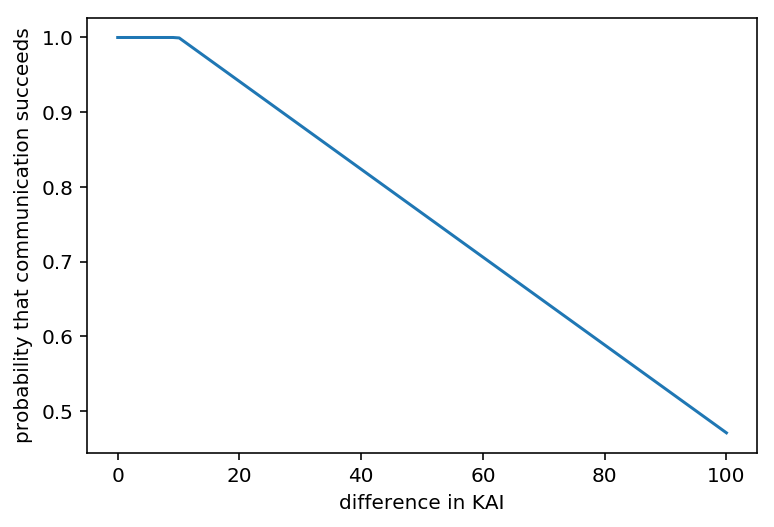

In [90]:
deltaAis = np.linspace(0,100,100)
# pSuccess = []
# for deltaAi in deltaAis: #hard to communicate above 20, easy below 10
#     successful = []
#     for i in range(1000):
#         successful.append(tryComm(deltaAi))
#     pSuccess.append(np.mean(successful))
theoreticalP = [min(1 - (d-10)/170,1) for d in deltaAis]
plt.plot(deltaAis,theoreticalP)
# plt.plot(deltaAis,pSuccess)
plt.xlabel("difference in KAI")
plt.ylabel("probability that communication succeeds")
plt.savefig("./figs/successfullP.pdf")

In [91]:
# nAgents = 22
# steps = 1
# teamDims, agentTeams = saeTeams(nAgents)
# team = teamWorkSpecialized(nAgents,constructor,teamDims,agentTeams,showViz=showViz,speed=None,pComm=pComm,steps=steps,groupConformityBias=True,soBias=True,aiScore=aiScore,aiRange=aiRange)

# print(team.agents[0].score)
# print(team.agents[11].score)
# print(team.getBestScore())
# team.haveSubTeamMeeting(0)
# print(team.agents[0].score)
# print(team.agents[11].score)
# print(team.getBestScore())

# Individual Exploration

In [92]:
# def work(AgentConstructor,steps=100,ai=None,temp=None, speed=None, showViz=False, soBias=False, groupConformityBias = False, color = 'red',startPosition = None,teamPosition=None):    
#     a = AgentConstructor()
#     if ai is not None:
#         a.kai = findAiScore(ai)
#         self.speed = bounds(AVG_SPEED + normalizedAI(self.kai.KAI) * SD_SPEED, MIN_SPEED ,np.inf)
#         self.temp = bounds(AVG_TEMP + normalizedE(self.kai.E) * SD_TEMP, 0 ,np.inf)
#     if startPosition is not None:
#         a.startAt(startPosition)
#     if temp is not None:
#         a.temp = temp
#     if speed is not None:
#         a.speed = speed
    
#     a.decay = calculateAgentDecay(a, steps)

#     scores = []
#     shareSuccess = []          

#     for i in range(steps):
#         didMove = a.move(soBias=soBias,groupConformityBias = groupConformityBias,teamPosition = teamPosition)
#         if didMove:
#             scores.append(copy.deepcopy(a.score))
#             if(showViz and a.nmoves>0):
# #                     plt.scatter(a.rNorm[0],a.rNorm[1],c=color)
#                 plt.scatter(a.rNorm[0],a.score,c=color)
#         a.speed *= a.decay
#         a.temp *= a.decay

#     return a

# Team Work

In [144]:
# meetingTimes = 20
def teamWork(teamSize,agentConstructor, pComm, steps=100, soBias=False,groupConformityBias=False, speed=None, temp=None, showViz=False,aiScore=None,aiRange=None,startPositions=None):
    meetingTotals = []
    squad = Team(teamSize,agentConstructor,temp=temp,speed=speed,aiScore=aiScore,aiRange=aiRange,startPositions=startPositions)
    for a in squad.agents:
        a.decay = calculateAgentDecay(a,steps)
    
    meetingTotal = 0
    i = 0
    while i < steps:
        meetingTotal += squad.step(pComm,showViz,soBias,groupConformityBias) 
#         if showViz: 
#             rGroup = squad.getSharedPosition()
#             plt.scatter(rGroup[0],rGroup[1],marker='o',s=100,c='black')
        
        if (i+1)%meetingTimes == 0: 
            squad.haveTeamMeeting()
            squad.nTeamMeetings +=1
            i += TEAM_MEETING_COST
            if(showViz): 
                plt.show()
        i += 1
    if showViz: plt.show()
    meetingTotals.append(meetingTotal)
    
    return squad

# meetingTimes = 20
def teamWorkSpecialized(teamSize,agentConstructor,teamSpecializations,agentTeams, pComm, steps=100, soBias=False,groupConformityBias=False, speed=None, temp=None, showViz=False,aiScore=None,aiRange=None,startPositions=None):
    np.random.seed()
    meetingTotals = []
    squad = Team(teamSize,agentConstructor,temp=temp,speed=speed,aiScore=aiScore,aiRange=aiRange,startPositions=startPositions,specializations = teamSpecializations)
    for i in range(len(squad.agents)):
        a = squad.agents[i]
        aTeam = agentTeams[i]
        a.team = aTeam
        a.myDims = teamSpecializations[aTeam]
        a.decay = calculateAgentDecay(a,steps)
    
    meetingTotal = 0
    i = 0 #not for loop bc we need to increment custom ammounts inside loop
    while i < steps:
#                 pCi = pComm #*(i/steps) #we can make them wait until later to communicate
        meetingTotal += squad.step(0,showViz,soBias,groupConformityBias)  #putting 0 for pComm here!
        score = squad.getBestScore()
        squad.scoreHistory.append(score)
        if showViz: 
            plt.scatter(i,score,marker='o',s=100,c='black')
        
        if (i+1)%meetingTimes == 0: 
            squad.haveInterTeamMeeting()
            squad.nTeamMeetings +=1
            i += TEAM_MEETING_COST
#             if showViz: 
#                 plt.show()

        #use pComm for subTeam meetings instead of pair meetings
        for team in range(len(squad.specializations)): 
            if pComm > np.random.uniform(): #on any step there is some chance of having a meeting
                squad.haveSubTeamMeeting(team,gap=complexSharing)
                squad.subTeamMeetings += 1
        i += 1
    if showViz: plt.show()
    meetingTotals.append(meetingTotal)
    
    return squad

def teamWorkSharing(teamSize,agentConstructor,teamSpecializations,agentTeams, pComm, steps=100, soBias=False,groupConformityBias=False, speed=None, temp=None, showViz=False,aiScore=None,aiRange=None,startPositions=None, curatedTeams=False):
    np.random.seed()
    squad = Team(teamSize,agentConstructor,temp=temp,speed=speed,aiScore=aiScore,aiRange=aiRange,startPositions=startPositions,specializations = teamSpecializations)
    
    for i in range(len(squad.agents)):
        a = squad.agents[i]
        aTeam = agentTeams[i]
        a.team = aTeam
        a.myDims = teamSpecializations[aTeam]
        a.decay = calculateAgentDecay(a,steps)
    if curatedTeams:
        for team in range(len(teamSpecializations)):
            teamAgents=[a for a in squad.agents if a.team == team]
            for i in range(len(teamAgents)):
                myKai = aiScore - aiRange/2.0 + aiRange*(float(i)/(len(teamAgents)-1)) 
                a= teamAgents[i]
                a.kai = findAiScore(myKai)
                           
    i = 0 #not for loop bc we need to increment custom ammounts inside loop
    while i < steps:
#                 pCi = pComm #*(i/steps) #we can make them wait until later to communicate
        squad.nMeetings += squad.step(pComm,showViz,soBias,groupConformityBias) 
        score = squad.getBestScore()
        squad.scoreHistory.append(score)
        if showViz: 
            plt.scatter(i,score,marker='o',s=100,c='black')
        
        if (i+1)%meetingTimes == 0: 
            squad.haveInterTeamMeeting()
            squad.nTeamMeetings +=1
            i += TEAM_MEETING_COST
#             if showViz: 
#                 plt.show()
        i += 1
    if showViz: plt.show()
    
    return squad

In [175]:
#define the team specializations and assign agents to teams
def specializedTeams(nAgents,nDims,nTeams):
    teamDimensions = np.array([[1 if t%nTeams == dim%nTeams else 0 for dim in range(nDims)] for t in range(nTeams)])
    agentTeams = np.array([a%nTeams for a in range(nAgents)])
    return teamDimensions, agentTeams

teams = ['brk', 'c', 'e', 'ft', 'fw', 'ia','fsp','rsp', 'rt', 'rw', 'sw']
teamsDict = { i:teams[i] for i in range(10)}
paramTeams = paramsDF.team
nTeams = len(teams)
teamDimensions_CONST = [[ 1 if paramTeam == thisTeam else 0 for paramTeam in paramTeams] for thisTeam in teams]
    
def saeTeams(nAgents):
    for i in range(nAgents):
        agentTeams = np.array([a%nTeams for a in range(nAgents)])
    return agentTeams

In [95]:
def showScoreHistory(agent):
    mem = agent.memory
    for i in range(len(mem)):
        m = mem[i]
        plt.scatter(i,m.score,c='b')
    plt.show()
def showPath(agents):
    for agent in agents:
        mem = agent.memory
        dims = [i for i in range(len(agent.myDims)) if agent.myDims[i]>0]
        x = []
        y = []
        for i in range(len(mem)):
            m = mem[i]
            x.append(m.r[dims[0]])
            y.append(m.r[dims[1]])
        plt.scatter(x,y,c=aiColor(agent.kai.KAI))
        plt.xlabel(paramsDF.name[dims[0]])
        plt.ylabel(paramsDF.name[dims[1]])
        plt.scatter(agent.r[dims[0]],agent.r[dims[1]],marker='x',s=100,c=aiColor(agent.kai.KAI))
    plt.show()
# a0 = team.agents[9]
# showScoreHistory(a0)
# a0.myDims

In [171]:
#set standard Parameters
def resetDefaultParameters():
    steps = 500 #0 #100
    nAgents = 33
    constructor = carDesigner
    teamDims = [[ 1 if paramTeam == thisTeam else 0 for paramTeam in paramTeams] for thisTeam in teams]
    agentTeams = saeTeams(33)#[[ 1 if paramTeam == thisTeam else 0 for paramTeam in paramTeams] for thisTeam in teams]

    RG_STRENGTH = 10
    SO_STRENGTH = 10
    commBonus = 10
    commRange = 180

    AVG_SPEED = 0.7E-2
    SD_SPEED = 0.7E-3
    MIN_SPEED = 1.0E-4
    AVG_TEMP = 1
    SD_TEMP = 0.8

    pComm = 0.2
    meetingTimes = steps #have one meeting at the end
    TEAM_MEETING_COST = 1

    VERBOSE = False
    showViz = False
    pairSharingOn = True
    complexSharing = True
    nDims = len(paramsDF)

    aiScoresMeans = [None]#np.linspace(80,120,3)
    aiRanges = [None] # np.linspace(0,30,2)

# visualize the solution?

In [181]:
# team0 = teamWorkSharing(nAgents,constructor,teamDims,agentTeams,showViz=showViz,speed=None,pComm=pComm,steps=steps,groupConformityBias=True,soBias=True,aiScore=aiScore,aiRange=aiRange)
s0 = team0.getBestSolution()
carDesign = asParameters(s0.r)

divide by zero (dn)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


TypeError: object of type 'numpy.int64' has no len()

In [98]:
print("cabin len, m: " +str(carDesign.lc))
print("front wing angle, deg: " +str(carDesign.afw*180/np.pi))

NameError: name 'carDesign' is not defined

In [99]:
p = startParams()

In [100]:
print("random start point:")
print("cabin len, m: " +str(p.lc))
print("front wing angle, deg: " +str(p.afw*180/np.pi))

random start point:
cabin len, m: 1.525
front wing angle, deg: 22.96603615023486


## Run SAE team

In [101]:
resetDefaultParameters()

In [102]:
# for k in range(reps):
# #     if k%10 == 0:
# #         startPositions = np.random.uniform(-1*startRange,startRange,[teamSize,nDims])
#     for i in range(len(aiRanges)):
#         aiRange = aiRanges[i]
#         for j in range(len(aiScoresMeans)):
#             aiScore = aiScoresMeans[j]
#             team = teamWorkSpecialized(nAgents,constructor,teamDims,agentTeams,showViz=showViz,speed=None,pComm=pComm,steps=steps,groupConformityBias=True,soBias=True,aiScore=aiScore,aiRange=aiRange)
#             score = team.getBestScore()
#             scores.append(score)
#             aiScores = [a.kai.KAI for a in team.agents]
#             aiTeamMeans.append(np.mean(aiScores))
#             aiTeamRange.append(np.max(aiScores) - np.min(aiScores))
#             nMeetings.append(team.nMeetings)
#             teamMeetings.append(team.nTeamMeetings)
#             scoreMatrix[i,j] += score
#             plt.clf()
#             plt.plot(range(len(team.scoreHistory)),team.scoreHistory)
#             plt.ylim([-3,0])
#             plt.xlim([0,100])
#             plt.savefig("./figs/teamScores_mu:"+str(aiScore)+"_sd:"+str(aiRange)+"_"+str(timer.time())+".pdf")
# #             print(team.nMeetings)
# scoreMatrix = np.array(scoreMatrix) / reps #the average score
# print("time to complete: "+str(timer.time() - t))
# print("ai ranges: "+str(aiRanges))
# print("ai means: "+str(aiScoresMeans))
# print("reps:" +str(reps))
# np.savetxt("./results/scoreMatrix_+"+str(timer.time())+".csv", scoreMatrix, delimiter=",")

## Use MultiProcessing for parallel computing

In [176]:
curatedTeams = False
def teamWorkProcess(processID):
    np.random.seed()
    team = teamWorkSharing(nAgents,constructor,teamDimensions_CONST,agentTeams,showViz=showViz,speed=None,pComm=pComm,steps=steps,groupConformityBias=True,soBias=True,aiScore=aiScore,aiRange=aiRange,curatedTeams=curatedTeams)
    return team

In [104]:
# !jupyter nbconvert --to script Chicago.ipynb

# Problem Solving Styles and paramter tuning

In [196]:
#first: how much is their style affecting their behavior?
resetDefaultParameters()
t0 = timer.time()
allTeamObjects = []

resetDefaultParameters()
reps = 1
nAgents = 33
agentTeams = saeTeams(nAgents)

steps = 50
aiScoresMeans = [100]
aiRanges = [90]
pComms = [0.2]
meetingTimes = 10 #team meating every how many steps?
for i in range(reps):
    for pComm in pComms:
        for aiScore in aiScoresMeans:
            for aiRange in aiRanges:
                team = teamWorkSharing(nAgents,constructor,teamDimensions_CONST,agentTeams,showViz=showViz,speed=None,pComm=pComm,steps=steps,groupConformityBias=True,soBias=True,aiScore=aiScore,aiRange=aiRange)
                allTeamObjects.append(team)
print("time to complete: "+str(timer.time()-t0))

time to complete: 9.17118215560913


In [197]:
team0 = allTeamObjects[0]
team0.nTeamMeetings

10

mixed team


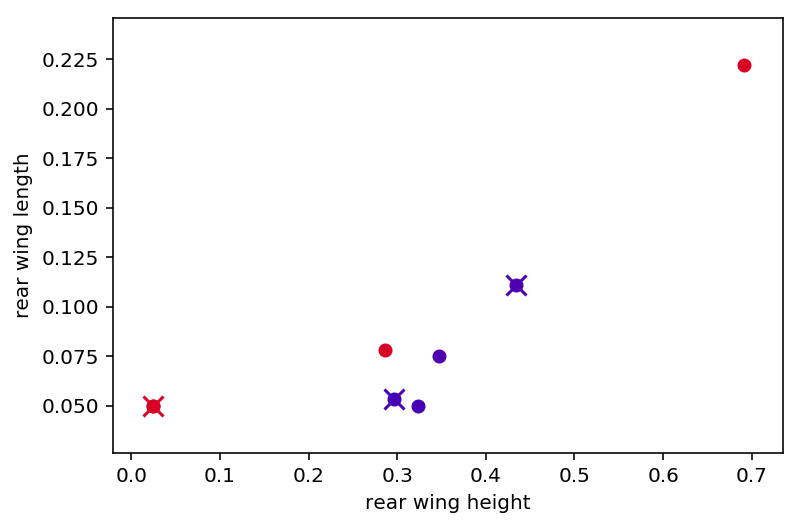

In [191]:
team = allTeamObjects[0]
t = 9
a0 = team.agents[t]
a1 = team.agents[t+11]
a2 = team.agents[t+22]

print("mixed team")
showPath([a0,a1,a2])

In [ ]:
t0 = timer.time()
resetDefaultParameters()

pComm = 0.2
pComms = [0.2]# np.linspace(0,.3,20)

VERBOSE = False
showViz = False

reps = 4 # 10 #$40 #5

aiScoresMeans = [100]#np.linspace(80,120,3)
aiRanges = [0] # np.linspace(0,30,2)

meetingTimes = steps #have one meeting at the end
TEAM_MEETING_COST = 1


scoreMatrix = np.zeros([len(aiRanges),len(aiScoresMeans)])

exitFlag = 0

allTeamObjects = []

for pComm in pComms:   
    if __name__ == '__main__':
        pool = multiprocessing.Pool(processes = 4)
        allTeams = pool.map(teamWorkProcess, range(reps))#[pool.apply_async(teamWorkProcess, (i,)) for i in range(reps)]
        print('moving on')
        for team in allTeams:
            allTeamObjects.append(team)
# allTeams = [t for tl in allTeamObjects for t in tl]
print("time to complete: "+str(timer.time()-t0))
allTeams = allTeamObjects
chaching()

In [179]:
t0 = timer.time()
resetDefaultParameters()
curatedTeams = True

pComm = 0.2
pComms = [0.2]# np.linspace(0,.3,20)

steps = 50
reps = 4 # 10 #$40 #5

aiScoresMeans = [100]#np.linspace(80,120,3)
aiRanges = [0] # np.linspace(0,30,2)

meetingTimes = steps #have one meeting at the end

allTeamObjects = []
for pComm in pComms:   
    if __name__ == '__main__':
        pool = multiprocessing.Pool(processes = 4)
        allTeams = pool.map(teamWorkProcess, range(reps))
        print('moving on')
        for team in allTeams:
            allTeamObjects.append(team)
# allTeams = [t for tl in allTeamObjects for t in tl]
print("time to complete: "+str(timer.time()-t0))
allTeams = allTeamObjects
chaching()

TypeError: unsupported operand type(s) for /: 'NoneType' and 'float'

In [ ]:
allScores = [t.getBestScore() for t in allTeamObjects]
nShares = [t.nMeetings/nAgents for t in allTeamObjects]
plt.scatter(nShares,allScores)

ValueError: x and y must be the same size

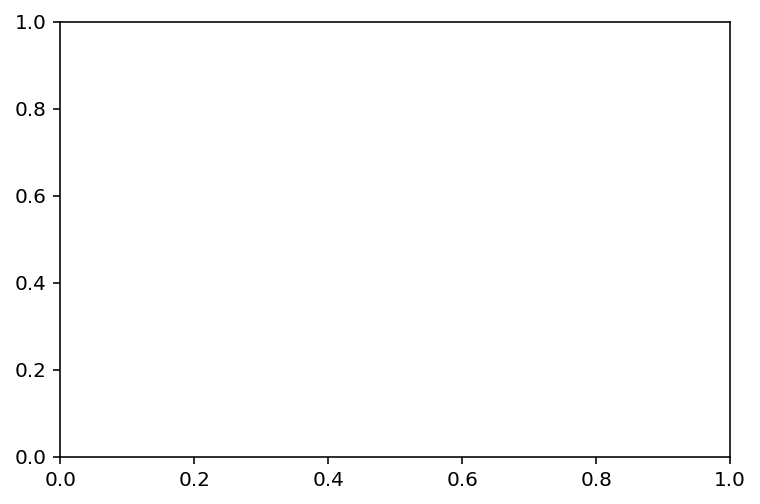

In [150]:
allScores = [t.getBestScore() for t in allTeamObjects]
scoresForPComm = []
for i in range(int(len(allScores)/4)):
    theseScores = allScores[0+i*4:4+i*4]
    scoresForPComm.append(np.mean(theseScores))
plt.scatter(pComms,scoresForPComm)
plt.title("avg score vs pComm")
plt.savefig("./figs/avgScore_Vs_pComm.pdf")

In [270]:
scoresForPComm

[-2.039567859600141,
 -2.3723489379415725,
 -2.5074387728312346,
 -2.5356173009237106,
 -2.6708729308720294,
 -2.6598657473999867,
 -2.3124368793668864]

In [233]:
# bigTeamSet= bigTeamSet[0:20]
# for t in allTeamObjects:
#     bigTeamSet.append(t)
# len(bigTeamSet)
# bigTeamSet = [i for l in bigTeamSet for i in l]

28

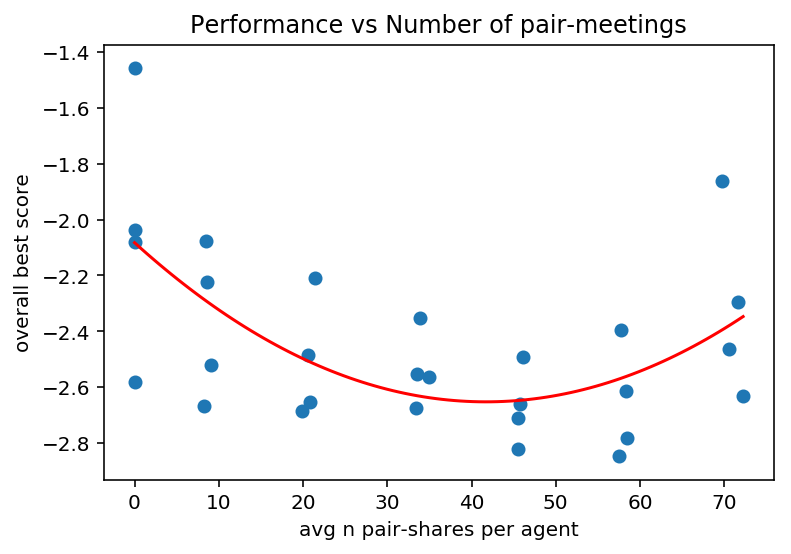

In [236]:
x = np.array([t.nMeetings / 33 for t in bigTeamSet])
yr = np.array([t.getBestScore() for t in bigTeamSet])
# xcat = [round(i*2,-1)/2 for i in x]
plt.scatter(x,yr)
p = np.polyfit(x,yr,2)
z = np.poly1d(p)
x1 = np.linspace(0,max(x),100)
plt.plot(x1,z(x1),color='red')
plt.title('Performance vs Number of pair-meetings')
plt.xlabel("avg n pair-shares per agent")
plt.ylabel("overall best score")
t = str(timer.time())
np.savetxt("./savedParams/"+t+".txt",[makeParamString()], fmt='%s')
plt.savefig("./figs/pairwiseSharing_noReset_"+t+".pdf")

In [393]:
#bootstrapping for mean and sd of minimum point
bestNshares = []

allInd = range(len(bigTeamSet))
for i in range(1000):
    ind = np.random.choice(allInd,14)
    teams = [bigTeamSet[j] for j in ind]
    x = [t.nMeetings/33 for t in teams]
    y = [t.getBestScore() for t in teams]
    x1 = np.linspace(min(x),max(x),300)
    p = np.polyfit(x,y,2)
    z = np.poly1d(p)
    predicted = z(x1)
    bestNshares.append(x1[np.argmin(predicted)])
    
print("best n shares per agent:")
print("mean:" +str(np.mean(bestNshares)))
print("std: "+str(np.std(bestNshares)))

best n shares per agent:
mean:43.4431558731124
std: 9.50356733199722


## Organic Team Composition

In [116]:
t0 = timer.time()
resetDefaultParameters()
reps = 16 # 10 #$40 #5

aiScoresMeans = [None]#np.linspace(80,120,3)
aiRanges = [None] # np.linspace(0,30,2)

meetingTimes = steps #have one meeting at the end

allTeamObjects = []

for aiScore in aiScoresMeans:
    for aiRange in aiRanges:
        if __name__ == '__main__':
            pool = multiprocessing.Pool(processes = 4)
            allTeams = pool.map(teamWorkProcess, range(reps))#[pool.apply_async(teamWorkProcess, (i,)) for i in range(reps)]
            print('moving on')
            for team in allTeams:
                allTeamObjects.append(team)
print("time to complete: "+str(timer.time()-t0))
allTeams = allTeamObjects
chaching()

Process ForkPoolWorker-10:
Process ForkPoolWorker-11:
Process ForkPoolWorker-9:
Process ForkPoolWorker-12:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()


KeyboardInterrupt: 

  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/anaconda3/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/anaconda3/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/anaconda3/lib/python3.6/multiproce

In [ ]:
tMeans = []
tSds = []
tScores = [] 
tRanges = []
tMeetings = []
for t in allTeamObjects:
    kais = [a.kai.KAI for a in t.agents]
    tMeans.append(np.mean(kais))
    tRanges.append(np.max(kais)-np.min(kais))
    tSds.append(np.std(kais))
    tScores.append(t.getBestScore())
    tMeetings.append(t.nMeetings)

In [ ]:
plt.scatter(tMeans,tScores)
p=np.polyfit(tMeans,tScores,1)
print("scores vs means")
print(p)
f = np.poly1d(p)
x = np.linspace(min(tMeans),max(tMeans),100)
plt.plot(x,f(x))

In [ ]:
plt.scatter(tSds,tScores)
p=np.polyfit(tSds,tScores,1)
print("scores vs stdevs")
print(p)
f = np.poly1d(p)
x = np.linspace(min(tSds),max(tSds),100)
plt.plot(x,f(x))

## Specific Make-up Teams

In [348]:
t0 = timer.time()
resetDefaultParameters()

reps = 4
aiScoresMeans = [100]#np.linspace(80,120,3)
aiRanges = np.linspace(0,100,8)

allTeamObjects = []
for aiScore in aiScoresMeans:
    for aiRange in aiRanges:
        if __name__ == '__main__':
            pool = multiprocessing.Pool(processes = 4)
            allTeams = pool.map(teamWorkProcess, range(reps))#[pool.apply_async(teamWorkProcess, (i,)) for i in range(reps)]
            print('moving on')
            for team in allTeams:
                allTeamObjects.append(team)
print("time to complete: "+str(timer.time()-t0))
chaching()

moving on
moving on
moving on
moving on
moving on
moving on
moving on
moving on
time to complete: 907.2802548408508


In [349]:
def getBestScoreAtTime(team,t):
    # t is fraction of time in simulation. this is approximate
    scores = []
    for a in team.agents:
        ml = len(a.memory)
        memorySubset = a.memory[0:int(ml*t)]
        scores.append(np.min([m.score for m in memorySubset]))
    return min(scores)

In [350]:
# allTeamObjects1 = allTeamObjects
# for t in allTeamObjects:
#     allTeamObjects1.append(t)

In [394]:
tMeans = []
tSds = []
tScores = [] 
tRanges = []
tMeetings = []
bestScoresAtFraction = []
so = []
rg = []
e = []
for t in allTeamObjects:
    if t.getBestScore()>-2: continue
    kais = [a.kai.KAI for a in t.agents]
    tMeans.append(np.mean(kais))
    tRanges.append(np.max(kais)-np.min(kais))
    
    tSds.append(np.std(kais))
    tScores.append(t.getBestScore())
    tMeetings.append(t.nMeetings)
    bestScoresAtFraction.append(getBestScoreAtTime(t,.25))
    
    sos = [a.kai.SO for a in t.agents]
    so.append(np.mean(sos))
    
    es = [a.kai.E for a in t.agents]
    e.append(np.mean(es))
    
    rgs = [a.kai.RG for a in t.agents]
    rg.append(np.mean(rgs))

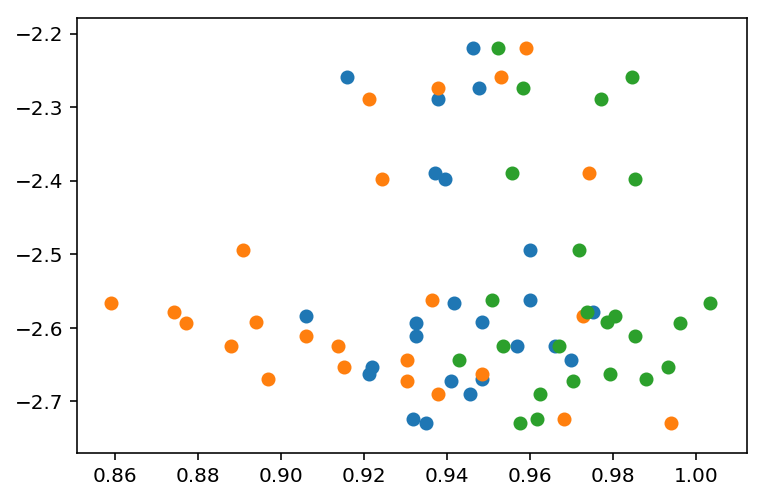

In [405]:
# any trends for subscores? not really
plt.scatter(np.array(rg)/40,tScores)
plt.scatter(np.array(e)/20,tScores)
plt.scatter(np.array(so)/45,tScores)

scores vs means
[-0.12731133 10.13473877]


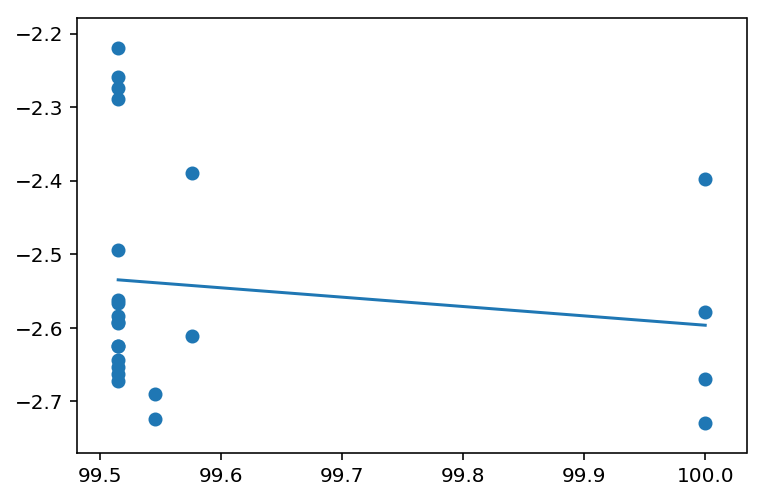

In [357]:
plt.scatter(tMeans,tScores)
p=np.polyfit(tMeans,tScores,1)
print("scores vs means")
print(p)
f = np.poly1d(p)
x = np.linspace(min(tMeans),max(tMeans),100)
plt.plot(x,f(x))

scores vs stdevs
[ 1.50189989e-03 -2.60862366e+00]


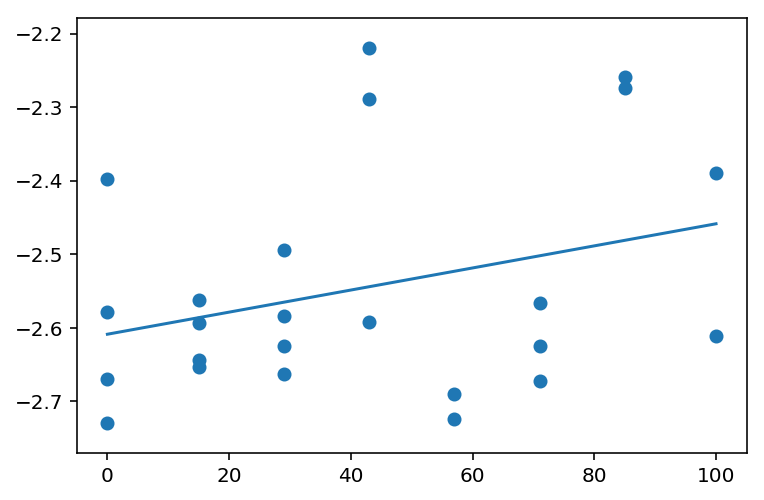

In [358]:
plt.scatter(tRanges,tScores)
p=np.polyfit(tRanges,tScores,1)
print("scores vs stdevs")
print(p)
f = np.poly1d(p)
x = np.linspace(min(tRanges),max(tRanges),100)
plt.plot(x,f(x))

scores vs stdevs
[ 0.00758675 -2.37335727]


Text(0.5,0,'range of KAI on team')

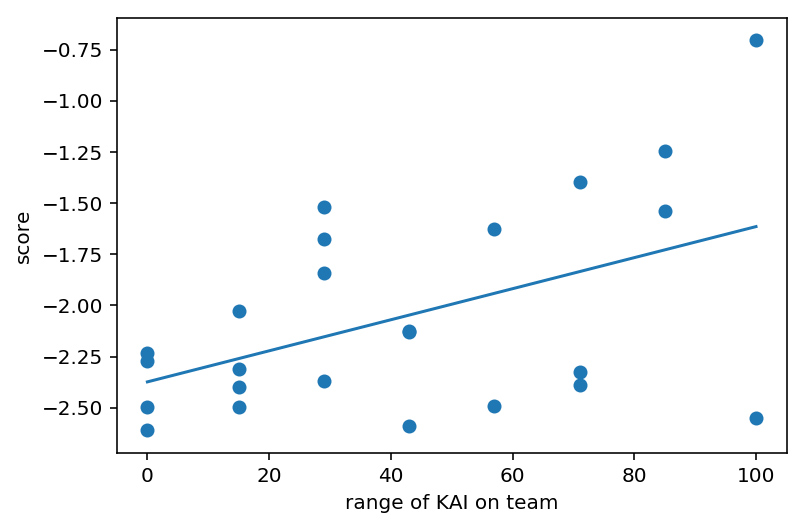

In [360]:
plt.scatter(tRanges,bestScoresAtFraction)
p=np.polyfit(tRanges,bestScoresAtFraction,1)
print("scores vs stdevs")
print(p)
f = np.poly1d(p)
x = np.linspace(min(tRanges),max(tRanges),100)
plt.plot(x,f(x))
plt.ylabel("score")
plt.xlabel("range of KAI on team")

In [ ]:
diverseTeams= [ t for t in allTeamObjects if t.dAI > 0]
uniformTeams = [ t for t in allTeamObjects if t.dAI == 0]
colors = ['red' if t.dAI > 0 else 'blue' for t in allTeamObjects ]
isDiverse = [True if t.dAI > 0 else False for t in allTeamObjects ]

In [ ]:
avgDiverseScore = np.mean([t.getBestScore() for t in diverseTeams])
avgUniformScore = np.mean([t.getBestScore() for t in uniformTeams])
std1 = np.std([t.getBestScore() for t in diverseTeams])
std2 = np.std([t.getBestScore() for t in uniformTeams])
print("diverse score avg:" + str(avgDiverseScore))
print("uniform score avg: " + str(avgUniformScore))
print("stds:" + str(std1) + " and "+str(std2))

In [ ]:
diverseScores = [t.getBestScore() for t in diverseTeams]
avgDiverseScore = np.mean(diverseScores)
uniformScores = [t.getBestScore() for t in uniformTeams]
avgUniformScore = np.mean(uniformScores)
std1 = np.std([t.getBestScore() for t in diverseTeams])
std2 = np.std([t.getBestScore() for t in uniformTeams])
print("diverse score avg:" + str(avgDiverseScore))
print("uniform score avg: " + str(avgUniformScore))
print("stds:" + str(std1) + " and "+str(std2))
stat, p = scipy.stats.ttest_ind(diverseScores,uniformScores)
print("significance: p= "+str(p))